In [1]:
# ============================================================
# FULL SCRIPT — THEMATIC ANALYSIS (BRAUN & CLARKE 2006)
# ============================================================

import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# ============================================================
# 1. LOAD DATA
# ============================================================
file_path = "/kaggle/input/data-hasil-interview/data-interview.xlsx"
df = pd.read_excel(file_path)

# Gabungkan semua jawaban menjadi satu list teks
text_columns = df.columns[4:]   # kolom berisi jawaban wawancara
all_text = []

for col in text_columns:
    for t in df[col].dropna():
        all_text.append(str(t))

# ============================================================
# 2. PREPROCESSING SIMPLE
# ============================================================
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    return text

cleaned = [clean_text(t) for t in all_text]

# ============================================================
# 3. INITIAL CODING (AUTOMATIC PHRASE EXTRACTION)
# ============================================================

vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             max_features=50,
                             stop_words='english')

X = vectorizer.fit_transform(cleaned)
phrases = vectorizer.get_feature_names_out()

initial_codes = phrases.tolist()

print("=== INITIAL CODES (AUTO TF-IDF PHRASES) ===")
for c in initial_codes:
    print("-", c)


# ============================================================
# 4. CLUSTERING — AUTOGROUPING CODES
# ============================================================
k = 7   # sesuai 7 tema final
model = KMeans(n_clusters=k, random_state=42)
model.fit(X)

clusters = model.labels_

clustered = {}
for idx, label in enumerate(clusters):
    clustered.setdefault(label, []).append(all_text[idx])

print("\n=== AUTO CLUSTERING PREVIEW ===")
for label, items in clustered.items():
    print(f"\nCLUSTER {label}:")
    for it in items[:4]:
        print("-", it[:120], "...")


# ============================================================
# 5. DEFINE FINAL THEMES (MANUAL OVERRIDE)
# ============================================================
themes = {
    1: "QA sebagai Penjaga Mutu Produk",
    2: "Keterlibatan QA yang Masih Reaktif",
    3: "Keterbatasan Infrastruktur & Tools QA",
    4: "Permasalahan Dokumentasi & Kualitas Requirement",
    5: "Kolaborasi Tim yang Belum Optimal",
    6: "Kesenjangan Skill QA",
    7: "Ekspektasi Peningkatan Kapabilitas QA"
}

# ============================================================
# 6. MATCH QUOTES TO THEMES (KEYWORD BASED)
# ============================================================

theme_keywords = {
    1: ["quality", "mutu", "validasi", "uji", "testing", "bug"],
    2: ["terlambat", "akhir", "reactive", "belakangan"],
    3: ["tools", "infrastruktur", "environment", "env", "staging"],
    4: ["requirement", "dokumen", "analisis", "spek", "document"],
    5: ["kolaborasi", "komunikasi", "tim", "scrum"],
    6: ["skill", "pengetahuan", "knowledge", "kemampuan"],
    7: ["harapan", "ekspektasi", "ke depan", "pengembangan", "update"]
}

def assign_theme(text):
    text_low = text.lower()
    score = {t: 0 for t in themes.keys()}

    for t, keys in theme_keywords.items():
        for kw in keys:
            if kw in text_low:
                score[t] += 1

    best = max(score, key=score.get)
    return best

df_quotes = []

for t in all_text:
    th = assign_theme(t)
    df_quotes.append([themes[th], t])

df_quotes = pd.DataFrame(df_quotes, columns=["Tema", "Kutipan"])

print("\n=== QUOTES PER THEME (EXTRACTED) ===")
for t in themes.values():
    print(f"\n--- {t} ---")
    subset = df_quotes[df_quotes["Tema"] == t].head(3)
    for q in subset["Kutipan"].tolist():
        print("•", q)


# ============================================================
# 7. SAVE OUTPUT (OPTIONAL)
# ============================================================
df_quotes.to_csv("hasil_thematic_analysis.csv", index=False)
print("\nFile 'hasil_thematic_analysis.csv' berhasil disimpan.")



=== INITIAL CODES (AUTO TF-IDF PHRASES) ===
- ada
- adalah
- adanya
- akan
- aplikasi
- automation
- baik
- bisa
- bug
- cukup
- dan
- dapat
- dari
- dengan
- developer
- di
- harus
- ini
- kami
- karena
- ke
- ketika
- komunikasi
- lebih
- lengkap
- melakukan
- namun
- nya
- oleh
- pada
- perlu
- project
- proses
- qa
- rasa
- saat
- saya
- saya rasa
- secara
- sehingga
- sudah
- test
- testing
- tidak
- tim
- tools
- untuk
- ya
- yang
- yg

=== AUTO CLUSTERING PREVIEW ===

CLUSTER 2:
- Sebenernya proses Quality Assurance sendiri terlibat dari tim product membuat dicument requirment (FSD kalo di faspay),  ...
- pada bagian project plan ketika tim business analyst telah membuat user story, kemudian dilakukan project plan sebelum d ...
- Dari awal sprint planing sudah mulai terlibat ...
- QA bisa memulai pada saat developer selesai melakukan development aplikasi dan menganggap sistem tersebut sudah bisa di  ...

CLUSTER 0:
- ketika fitur tersebut sudah selesai didevelopment oleh dev dan

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Total initial codes: 100


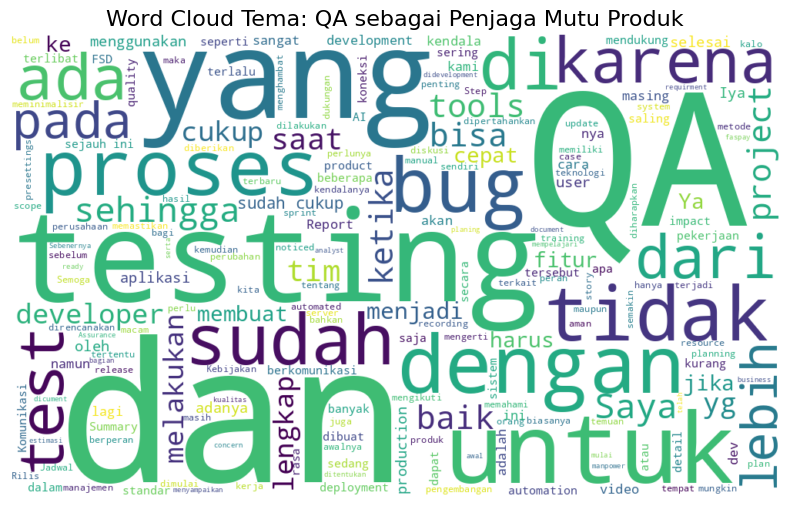

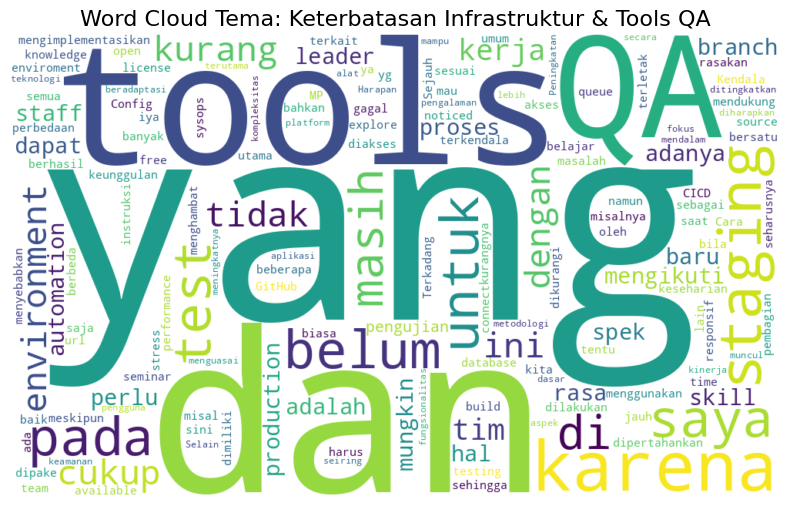

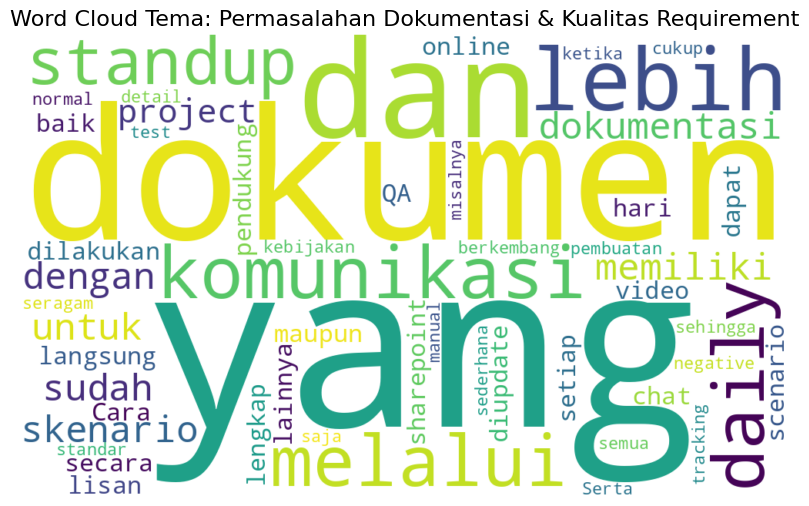

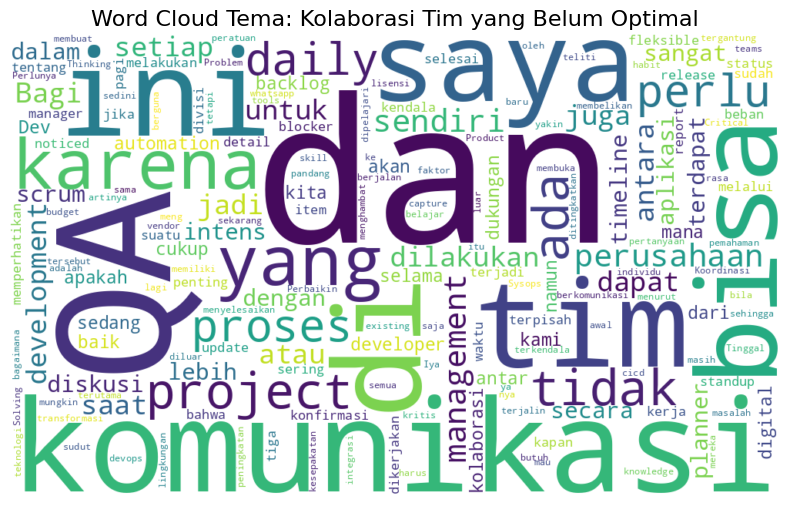

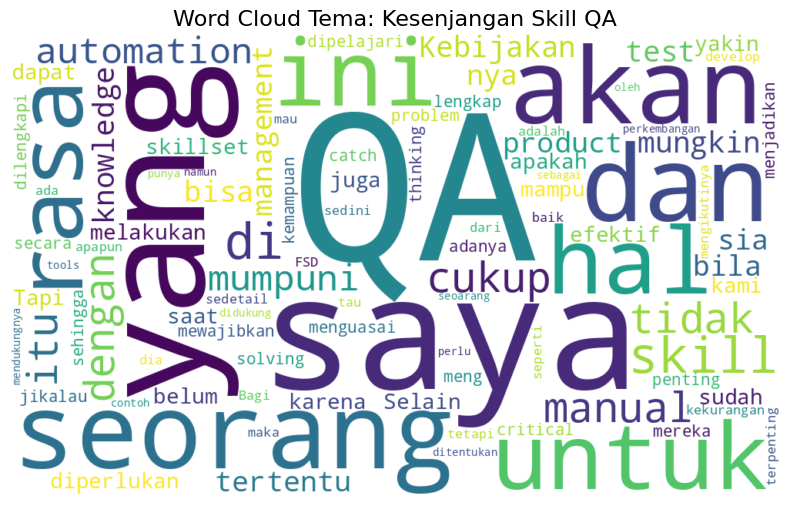

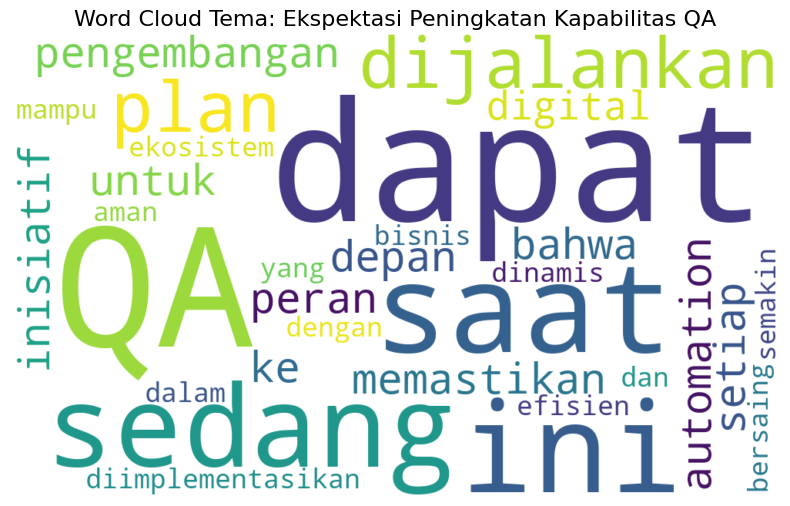

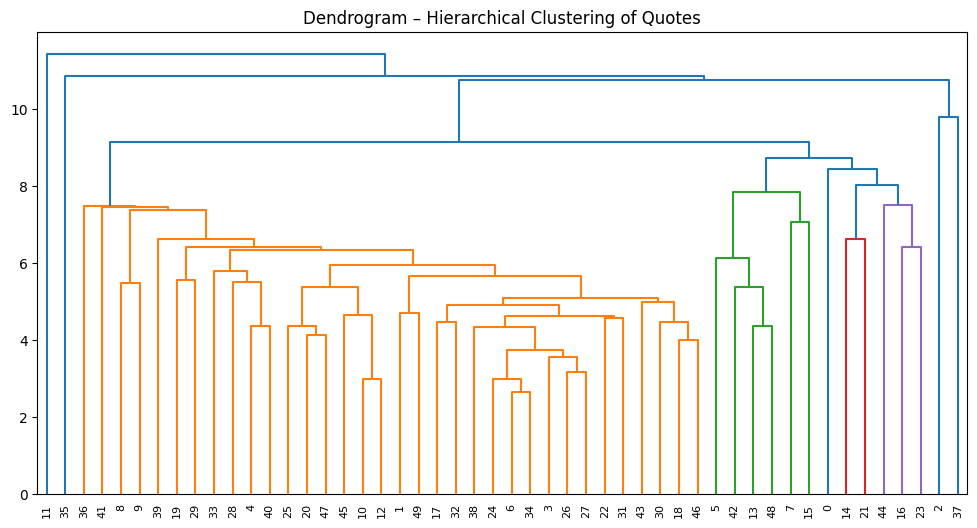

Coding tree saved as coding_tree_faspay.png


In [2]:
# ============================================================
# THEMATIC ANALYSIS + VISUALIZATION PACKAGE
# ============================================================

import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_extraction.text import CountVectorizer
import graphviz
import numpy as np

# ============================================================
# 1. LOAD DATA
# ============================================================

file_path = "/kaggle/input/data-hasil-interview/data-interview.xlsx"
df = pd.read_excel(file_path)

text_columns = df.columns[4:]
all_text = []

for col in text_columns:
    for t in df[col].dropna():
        all_text.append(str(t))

# ============================================================
# 2. CLEANING
# ============================================================

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    return text

cleaned = [clean_text(t) for t in all_text]

# ============================================================
# 3. TF-IDF + INITIAL CODES
# ============================================================

vectorizer = TfidfVectorizer(ngram_range=(1,2),
                             max_features=100,
                             stop_words="english")

X = vectorizer.fit_transform(cleaned)
phrases = vectorizer.get_feature_names_out()

print("Total initial codes:", len(phrases))

# ============================================================
# 4. FINAL THEMES (manual override)
# ============================================================

themes = {
    1: "QA sebagai Penjaga Mutu Produk",
    2: "Keterlibatan QA yang Masih Reaktif",
    3: "Keterbatasan Infrastruktur & Tools QA",
    4: "Permasalahan Dokumentasi & Kualitas Requirement",
    5: "Kolaborasi Tim yang Belum Optimal",
    6: "Kesenjangan Skill QA",
    7: "Ekspektasi Peningkatan Kapabilitas QA"
}

theme_keywords = {
    1: ["quality", "mutu", "testing", "bug", "validasi"],
    2: ["terlambat", "akhir", "reactive", "belakangan"],
    3: ["tools", "environment", "env", "staging"],
    4: ["requirement", "dokumen", "analisis", "spek"],
    5: ["kolaborasi", "komunikasi", "tim"],
    6: ["skill", "knowledge", "kemampuan"],
    7: ["harapan", "ekspektasi", "ke depan", "pengembangan"]
}

def assign_theme(text):
    score = {t:0 for t in themes.keys()}
    t_low = text.lower()
    for t, keys in theme_keywords.items():
        for kw in keys:
            if kw in t_low:
                score[t] += 1
    return max(score, key=score.get)

df_quotes = pd.DataFrame([
    [assign_theme(t), themes[assign_theme(t)], t]
    for t in all_text
], columns=["ID_Tema", "Tema", "Kutipan"])

# ============================================================
# 5. WORD CLOUD PER TEMA
# ============================================================

for t_id, tema in themes.items():
    subset = df_quotes[df_quotes["ID_Tema"] == t_id]["Kutipan"].tolist()
    combined = " ".join(subset)

    if len(combined.strip()) == 0:
        continue

    wc = WordCloud(width=1000, height=600, background_color="white").generate(combined)

    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud Tema: {tema}", fontsize=16)
    plt.show()

# ============================================================
# 6. DENDROGRAM — HIERARCHICAL CLUSTERING
# ============================================================

vectorizer_count = CountVectorizer(stop_words="english")
X_counts = vectorizer_count.fit_transform(cleaned).toarray()

Z = linkage(X_counts[:50], 'ward')   # sample 50 quotes

plt.figure(figsize=(12, 6))
plt.title("Dendrogram – Hierarchical Clustering of Quotes")
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.show()

# ============================================================
# 7. CODING TREE — NVIVO STYLE (GRAPHVIZ)
# ============================================================

dot = graphviz.Digraph(comment="Coding Tree")

dot.node("Root", "Thematic Analysis – Faspay QA")
for t_id, tema in themes.items():
    dot.node(f"T{t_id}", tema)
    dot.edge("Root", f"T{t_id}")

    subset = df_quotes[df_quotes["ID_Tema"] == t_id].head(3)
    for i, row in subset.iterrows():
        q = row["Kutipan"][:60] + "..."
        dot.node(f"T{t_id}_{i}", q)
        dot.edge(f"T{t_id}", f"T{t_id}_{i}")

dot.render("coding_tree_faspay", format="png", cleanup=True)
print("Coding tree saved as coding_tree_faspay.png")



In [3]:
# ============================================================
# FULL SCRIPT — THEMATIC ANALYSIS (BRAUN & CLARKE 2006)
# With Indonesian Stopwords Removal
# ============================================================

import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# ============================================================
# 0. STOPWORDS INDONESIA — EXTENDED (350+)
# ============================================================

stopwords_id = {
    "yang","yg","nya","dan","di","ke","dari","pada","dalam","itu","ini","untuk","atau","dengan",
    "karena","sebagai","bahwa","agar","jadi","adalah","oleh","antara","tanpa","kami",
    "kita","mereka","dia","saya","anda","kamu","juga","tidak","bukan","lebih","kurang",
    "setelah","sebelum","kembali","sudah","belum","masih","akan","dapat","bisa","harus",
    "hingga","supaya","walaupun","meskipun","sehingga","maupun","yakni","yaitu",
    "pun","lah","kah","tah","para","setiap","semua","beberapa","lagi","tentang",
    "terhadap","baik","namun","tetapi","melainkan","apabila","jika","bilamana",
    "ketika","sewaktu","dimana","kemana","kapan","bagaimana","berapa","sesuatu",
    "apapun","siapa","mana","betul","ya","iya","nah","oh","eh","loh","dong","kok",
    "punya","sampai","sekitar","setidaknya","misalnya","contohnya","seperti",
    "bahkan","justru","hanya","saja","maka","kemudian","lalu","serta","tetap",
    "walau","barangkali","mungkin","tentu","pastinya","sebenarnya","memang",
    "terus","kalau","kalo","gitu","begitu","kayak","kayaknya","padahal",
    "sementara","selama","sepanjang","sekiranya","andai","andaikan",
    "andaikata","andainya","kenapa","mengapa","apa","tersebut","tertentu",
    "berbagai","lain","lainnya","dll","dsb","dst","dll.","dsb.","dst.",
    # filler interview
    "jadi","kayak","misal","misalnya","ibaratnya","gitu","gini","kan","ya",
    "sebetulnya","sejujurnya","intinya","pokoknya","semacam","maksudnya",
    "sebagainya","dan sebagainya","dan lain-lain",
    # kata QA umum tidak bermakna
    "proses","hal","bagian","aspek","lebih","kurang","cukup","banyak",
    "sedikit","sering","jarang","dulu","kini","sekarang","contoh",
}

# fungsi hapus stopwords
def remove_stopwords(text):
    tokens = text.split()
    filtered = [t for t in tokens if t not in stopwords_id]
    return " ".join(filtered)


# ============================================================
# 1. LOAD DATA
# ============================================================

file_path = "/kaggle/input/data-hasil-interview/data-interview.xlsx"
df = pd.read_excel(file_path)

text_columns = df.columns[4:]
all_text = []

for col in text_columns:
    all_text.extend(df[col].dropna().astype(str).tolist())


# ============================================================
# 2. PREPROCESSING (BERSIHKAN KATA HUBUNG)
# ============================================================

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)  # hilangkan simbol
    text = re.sub(r'\s+', ' ', text).strip()
    text = remove_stopwords(text)               # HAPUS KATA HUBUNG
    return text

cleaned = [clean_text(t) for t in all_text]


# ============================================================
# 3. INITIAL CODING (AUTOMATIC PHRASE EXTRACTION)
# ============================================================

vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=50,
    stop_words=None   # <-- stopwords sudah dihapus manual
)

X = vectorizer.fit_transform(cleaned)
initial_codes = vectorizer.get_feature_names_out()

print("\n=== INITIAL CODES (SETELAH KATA HUBUNG DIHAPUS) ===")
for c in initial_codes:
    print("-", c)


# ============================================================
# 4. AUTO-CLUSTERING
# ============================================================

k = 7
model = KMeans(n_clusters=k, random_state=42)
model.fit(X)

clusters = model.labels_

clustered = {i: [] for i in range(k)}
for idx, label in enumerate(clusters):
    clustered[label].append(all_text[idx])

print("\n=== AUTO CLUSTERING PREVIEW ===")
for label, items in clustered.items():
    print(f"\nCLUSTER {label}:")
    for it in items[:3]:
        print("-", it[:120], "...")


# ============================================================
# 5. FINAL THEMES
# ============================================================

themes = {
    1: "QA sebagai Penjaga Mutu Produk",
    2: "Keterlibatan QA yang Masih Reaktif",
    3: "Keterbatasan Infrastruktur & Tools QA",
    4: "Permasalahan Dokumentasi & Kualitas Requirement",
    5: "Kolaborasi Tim yang Belum Optimal",
    6: "Kesenjangan Skill QA",
    7: "Ekspektasi Peningkatan Kapabilitas QA"
}


# ============================================================
# 6. MATCH QUOTES TO THEMES
# ============================================================

theme_keywords = {
    1: ["quality", "mutu", "validasi", "uji", "testing", "bug"],
    2: ["terlambat", "akhir", "reactive", "belakangan"],
    3: ["tools", "infrastruktur", "environment", "env", "staging"],
    4: ["requirement", "dokumen", "analisis", "spek", "document"],
    5: ["kolaborasi", "komunikasi", "tim", "scrum"],
    6: ["skill", "pengetahuan", "knowledge", "kemampuan"],
    7: ["harapan", "ekspektasi", "pengembangan", "update"]
}

def assign_theme(text):
    t_low = text.lower()
    score = {t: 0 for t in themes}

    for t, keys in theme_keywords.items():
        for kw in keys:
            if kw in t_low:
                score[t] += 1

    return max(score, key=score.get)

df_quotes = pd.DataFrame([
    [themes[assign_theme(t)], t]
    for t in all_text
], columns=["Tema", "Kutipan"])

print("\n=== QUOTES PER THEME ===")
for t in themes.values():
    print(f"\n--- {t} ---")
    print(df_quotes[df_quotes["Tema"] == t].head(3))


# ============================================================
# 7. SAVE OUTPUT
# ============================================================

df_quotes.to_csv("hasil_thematic_analysis.csv", index=False)
print("\nFile 'hasil_thematic_analysis.csv' berhasil disimpan.")



=== INITIAL CODES (SETELAH KATA HUBUNG DIHAPUS) ===
- ada
- adanya
- aplikasi
- automation
- bagi
- bug
- cara
- cepat
- daily
- detail
- dev
- developer
- development
- dilakukan
- fitur
- kebijakan
- kendala
- kerja
- knowledge
- komunikasi
- lengkap
- management
- manual
- melakukan
- membuat
- memiliki
- menggunakan
- menjadi
- perlu
- perusahaan
- product
- production
- project
- qa
- rasa
- report
- saat
- sangat
- secara
- sedang
- selesai
- sendiri
- skill
- staging
- test
- testing
- tim
- tim qa
- tools
- user

=== AUTO CLUSTERING PREVIEW ===

CLUSTER 0:
- pada bagian project plan ketika tim business analyst telah membuat user story, kemudian dilakukan project plan sebelum d ...
- Komunikasi dengan daily scrum dan update project di planner ...
- Saya noticed bahwa komunikasi antara QA, developer, dan project manager terjadi cukup sering di mana di perusahaan kami  ...

CLUSTER 1:
- Masih kurang karena masih menggunakan tools yg open source ...
- Saya rasa kurang,karena banya

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [4]:
# ============================================================
# 4. CLUSTERING & SAVING TO EXCEL
# ============================================================
k = 7
model = KMeans(n_clusters=k, random_state=42)
model.fit(X)

# 1. Create a mapping of Cluster ID to its Top Keywords
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

cluster_names = {}
for i in range(k):
    top_words = [terms[ind] for ind in order_centroids[i, :5]]
    cluster_names[i] = ", ".join(top_words)

# 2. Build the DataFrame
results_df = pd.DataFrame({
    'Cluster_ID': model.labels_,
    'Suggested_Theme_Keywords': [cluster_names[label] for label in model.labels_],
    'Original_Text': all_text
})

# 3. Sort by Cluster so similar themes are grouped together
results_df = results_df.sort_values(by='Cluster_ID')

# 4. Save to Excel
output_xlsx = "thematic_analysis_final.xlsx"

# Using ExcelWriter allows us to add a summary sheet if needed
with pd.ExcelWriter(output_xlsx, engine='openpyxl') as writer:
    # Main Data Sheet
    results_df.to_excel(writer, sheet_name='Clustered_Responses', index=False)
    
    # Summary Sheet (Just Themes and Counts)
    summary = results_df.groupby(['Cluster_ID', 'Suggested_Theme_Keywords']).size().reset_index(name='Response_Count')
    summary.to_excel(writer, sheet_name='Theme_Summary', index=False)

print(f"=== SUCCESS: Results saved to {output_xlsx} ===")

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


=== SUCCESS: Results saved to thematic_analysis_final.xlsx ===
